# Homework 1 - LISA Analysis of LIMA, Peru

**Student:** Aiden Dickson  
**Date:** December 26, 2025  
**Course:** DACSS 690C - Computational Social Science Methods  
**Variable:** Educ_sec_comp2019_pct (Share of Population that finished High-School)

In [40]:
# ============================================================================
# CODE CHUNK 1: Install and activate libraries needed
# ============================================================================
# This chunk installs and imports all necessary Python libraries for spatial analysis
# - geopandas: For working with geospatial data and shapefiles
# - pysal/libpysal: Core spatial analysis library
# - esda: Exploratory Spatial Data Analysis (includes LISA calculations)
# - pandas: For data manipulation and analysis
# - numpy: For numerical operations
# Note: In Google Colab, these libraries are usually pre-installed

# Import required libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.graph import Graph
from numpy.random import seed
import esda
import matplotlib.pyplot as plt

# Set random seed for reproducibility
# This ensures that any random processes (like LISA significance testing) 
# produce the same results each time the code is run
seed(42)

print("✓ All libraries successfully imported!")
print("✓ Random seed set to 42 for reproducibility")

✓ All libraries successfully imported!
✓ Random seed set to 42 for reproducibility


In [ ]:
# ============================================================================
# CODE CHUNK 2: Read the map of Peru (same layer used in class)
# ============================================================================
# This chunk reads the Peru geodata from GitHub repository
# The file is a GeoPackage (.gpkg) which can contain multiple map layers
# We're reading the 'good_geom' layer which contains distrito-level data

# GitHub URL for Peru map data
LinkPeru = "https://github.com/AidenFlowers/Computation-Social-Sci-Methods-DACSS-690C/raw/main/PeruMaps.gpkg"

# Read the Peru map from the GeoPackage file
# layer='good_geom' specifies which layer to read from the geopackage
peru = gpd.read_file(LinkPeru, layer='good_geom')

# Display basic information about the dataset
print(f"✓ Peru map loaded successfully")
print(f"Total number of districts in Peru: {len(peru)}")
print(f"Columns in dataset: {list(peru.columns)}")
print(f"\nFirst few rows:")
peru.head()

Current CRS: EPSG:5387
Current EPSG code: 5387
✓ Map is already projected

Final CRS: EPSG:5387
Final EPSG code: 5387
Is projected: True


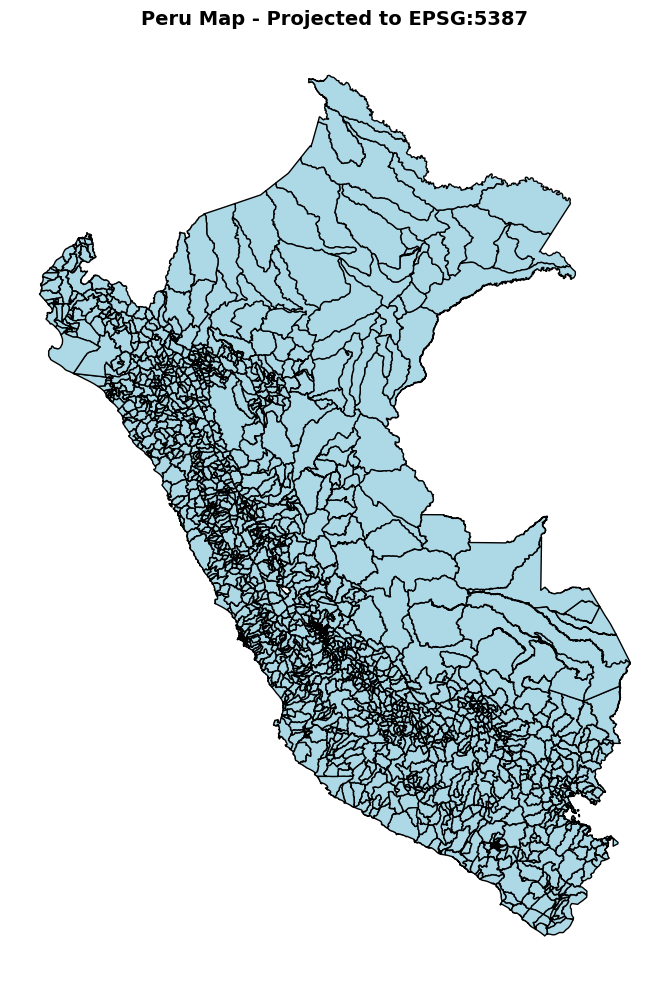

In [50]:
# ============================================================================
# CODE CHUNK 3: Verify if the map is projected, otherwise use CRS '5387'
# ============================================================================
# Coordinate Reference Systems (CRS) are critical for spatial analysis
# - Geographic CRS (like WGS84): Uses latitude/longitude, not projected
# - Projected CRS (like EPSG:5387): Uses meters/feet, better for analysis
# EPSG:5387 is Peru96 / UTM zone 18S - appropriate for Peru

# Check the current CRS
print(f"Current CRS: {peru.crs}")
print(f"Current EPSG code: {peru.crs.to_epsg()}")

# Check if the map is projected (False means it's geographic lat/lon)
if peru.crs is None or not peru.crs.is_projected:
    print("⚠ Map is NOT projected (uses lat/lon)")
    print("→ Reprojecting to EPSG:5387 (Peru96 / UTM zone 18S)")
    peru = peru.to_crs('EPSG:5387')
    print("✓ Map successfully reprojected!")
else:
    print("✓ Map is already projected")

# Verify the final CRS
print(f"\nFinal CRS: {peru.crs}")
print(f"Final EPSG code: {peru.crs.to_epsg()}")
print(f"Is projected: {peru.crs.is_projected}")

# Display the map to verify projection worked
fig, ax = plt.subplots(figsize=(10, 10))
peru.plot(ax=ax, edgecolor='black', facecolor='lightblue')
plt.title("Peru Map - Projected to EPSG:5387", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()



✓ Filtered to LIMA departamento
Number of districts in LIMA: 171
Shape of data: 171 rows × 10 columns

⚠ Warning: 4 duplicate district names found
         DISTRITO
827        LARAOS
979    MIRAFLORES
1365  SAN ANTONIO
1451     SAN LUIS
✓ DISTRITO set as index


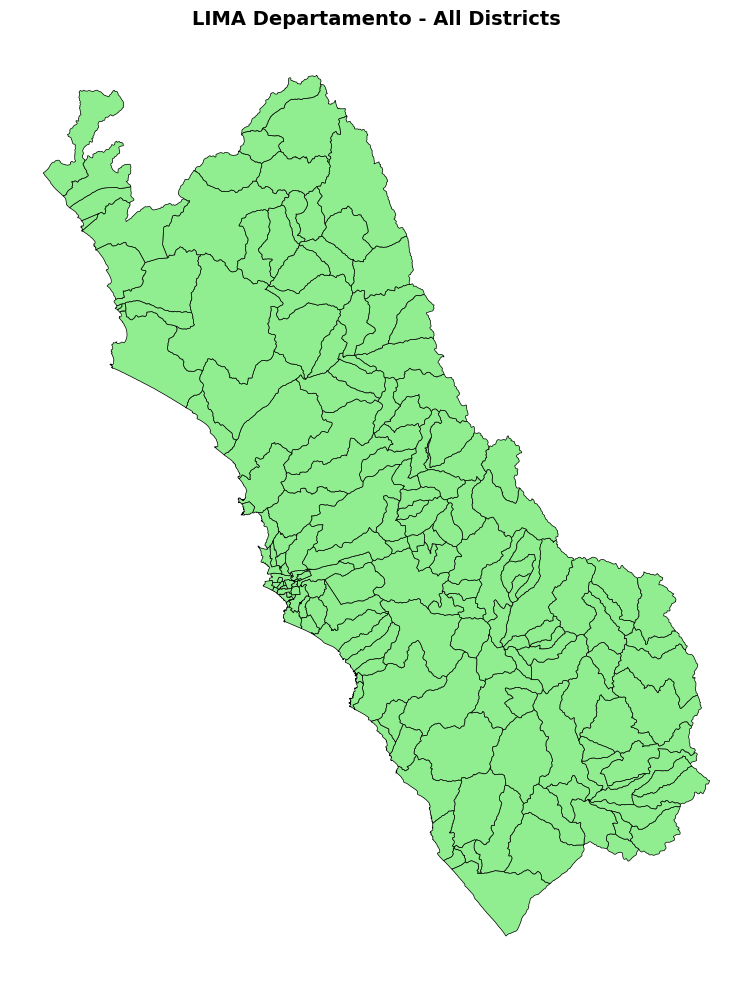


First few rows of LIMA data:


,DEPARTAMENTO,PROVINCIA,ubigeo,Poblacion,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct,geometry
DISTRITO,,,,,,,,,
ALIS,Lima,YAUYOS,PE151002,1233,0.646897,69.474298,30.3,6.6,"MULTIPOLYGON (((415396.076 8647591.116, 415450..."
AYAUCA,Lima,YAUYOS,PE151003,2293,0.544152,43.167400,61.9,57.2,"MULTIPOLYGON (((389530.693 8626520.884, 389743..."
AMBAR,Lima,HUAURA,PE150802,2761,0.316448,42.060097,73.3,60.2,"MULTIPOLYGON (((243293.978 8826436.11, 243328...."
ANCON,Lima,LIMA,PE150102,42124,0.668889,72.117976,21.7,1.1,"MULTIPOLYGON (((281417 8715329, 281397.439 871..."
ANDAJES,Lima,OYON,PE150902,1058,0.488913,71.684369,36.4,28.5,"MULTIPOLYGON (((291522.945 8820149.937, 291499..."


In [51]:
# ============================================================================
# CODE CHUNK 4: Keep the DEPARTAMENTO of 'LIMA'
# ============================================================================
# Peru is organized into DEPARTAMENTO (like states) → PROVINCIA → DISTRITO
# We're filtering to keep only districts within LIMA departamento
# LIMA is similar to a state/province in other countries

# Filter to keep only LIMA departamento
# .copy() creates an independent copy to avoid SettingWithCopyWarning
lima = peru[peru['DEPARTAMENTO'] == 'Lima'].copy()

print(f"✓ Filtered to LIMA departamento")
print(f"Number of districts in LIMA: {len(lima)}")
print(f"Shape of data: {lima.shape[0]} rows × {lima.shape[1]} columns")

# Check for duplicate district names (important for setting index later)
duplicates = lima[lima['DISTRITO'].duplicated()]
if len(duplicates) > 0:
    print(f"\n⚠ Warning: {len(duplicates)} duplicate district names found")
    print(duplicates[['DISTRITO']])
else:
    print("✓ No duplicate district names - safe to use as index")

# Set DISTRITO as the index for easier identification in outputs
# This replaces numeric indices (0,1,2...) with district names
lima.set_index('DISTRITO', inplace=True)
print("✓ DISTRITO set as index")

# Visualize LIMA departamento
fig, ax = plt.subplots(figsize=(12, 10))
lima.plot(ax=ax, edgecolor='black', facecolor='lightgreen', linewidth=0.5)
plt.title("LIMA Departamento - All Districts", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Display the data
print("\nFirst few rows of LIMA data:")
lima.head()

In [52]:
# ============================================================================
# CODE CHUNK 5: Get a neighborhood matrix using QUEEN
# ============================================================================
# QUEEN contiguity: Two polygons are neighbors if they share ANY boundary
# This includes sharing just a corner point (unlike ROOK which requires edge)
# This creates a spatial weights matrix defining neighbor relationships

# Build Queen contiguity spatial weights
# rook=False means we use Queen contiguity (the default, but explicit here)
lima = lima.reset_index()
w_queen = Graph.build_contiguity(lima, rook=False)

# Get cardinalities (number of neighbors per district) as a pandas Series
cards = w_queen.cardinalities
idx_to_name = lima['DISTRITO'].to_dict()

print("✓ Queen contiguity weights matrix created")
print(f"Number of spatial units: {w_queen.n}")
print(f"Average number of neighbors: {cards.mean():.2f}")
print(f"Minimum neighbors: {cards.min()}")
print(f"Maximum neighbors: {cards.max()}")

# Check for isolates (districts with no neighbors)
# Isolates can cause problems in spatial analysis
if len(w_queen.isolates) > 0:
    print(f"\n⚠ Warning: {len(w_queen.isolates)} isolate(s) found (no neighbors)")
    print(f"Isolates: {list(w_queen.isolates)}")
else:
    print("✓ No isolates found - all districts have at least one neighbor")

# Display the adjacency relationships (first few examples)
print("\nExample neighbor relationships:")
print("(Showing which districts are neighbors of each focal district)")
for focal in list(idx_to_name.keys())[:5]:  # First 5 districts
    neighbors = w_queen.adjacency[focal].index.tolist()
    focal_name = idx_to_name[focal]
    neighbor_names = [idx_to_name[n] for n in neighbors]
    print(f"{focal_name}: {neighbor_names}")

 

✓ Queen contiguity weights matrix created
Number of spatial units: 171
Average number of neighbors: 5.23
Minimum neighbors: 1
Maximum neighbors: 12
✓ No isolates found - all districts have at least one neighbor

Example neighbor relationships:
(Showing which districts are neighbors of each focal district)
ALIS: ['LARAOS', 'MIRAFLORES', 'TOMAS', 'VITIS']
AYAUCA: ['AYAVIRI', 'CACRA', 'CATAHUASI', 'CHOCOS', 'OMAS', 'PACARAN', 'PUTINZA', 'SAN PEDRO DE PILAS', 'TAURIPAMPA', 'VINAC', 'YAUYOS', 'ZUNIGA']
AMBAR: ['CAUJUL', 'COCHAMARCA', 'GORGOR', 'HUAURA', 'MANAS', 'NAVAN', 'SAYAN', 'SUPE']
ANCON: ['AUCALLAMA', 'CARABAYLLO', 'HUAMANTANGA', 'PUENTE PIEDRA', 'SANTA ROSA', 'SANTA ROSA DE QUIVES']
ANDAJES: ['CAUJUL', 'CHECRAS', 'GORGOR', 'OYON', 'PACHANGARA']


✓ Queen weights matrix normalized (row-standardized)
✓ LISA analysis complete (Queen weights)
Number of significant clusters/outliers: 67

Quadrant distribution (all districts):
lisa_queen
1    77
2    13
3    59
4    22
Name: count, dtype: int64


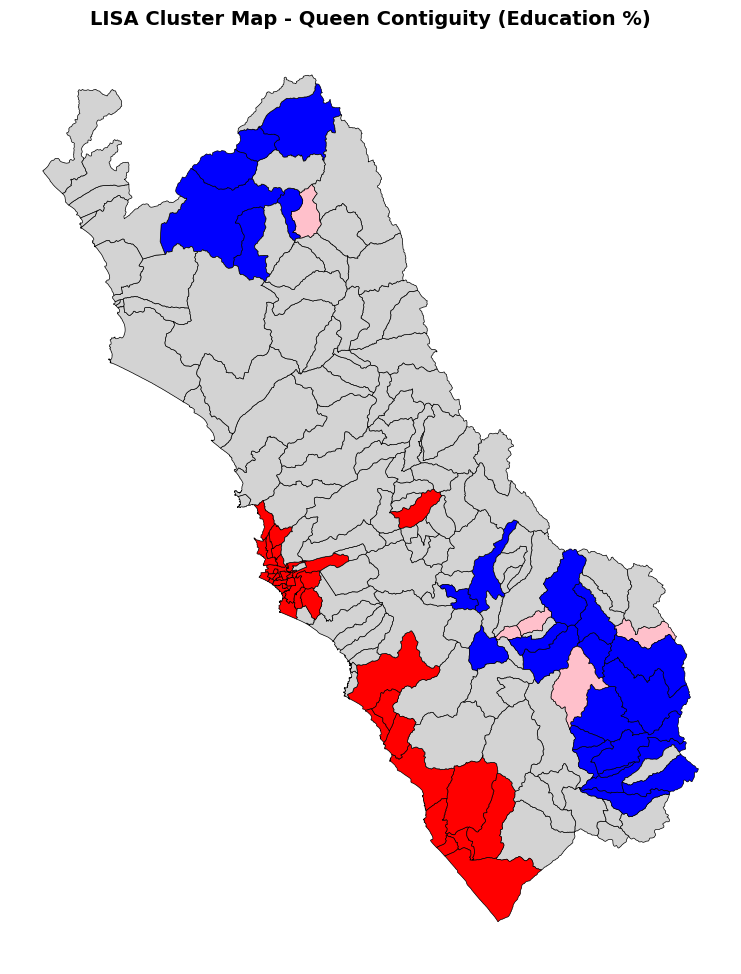

In [65]:
# ============================================================================
# CODE CHUNK 6: Produce the LISA MAP using the normalized neighborhood matrix
# ============================================================================
# LISA = Local Indicators of Spatial Association
# This identifies local clusters and outliers in our education data
# We use the Queen contiguity weights matrix created in Chunk 5

from esda.moran import Moran_Local

# Row-standardize (normalize) the Queen weights matrix
# 'r' means row-standardization: each row sums to 1
# This ensures each neighbor contributes equally regardless of number of neighbors
w_queen_normalized = w_queen.transform('r')
print("✓ Queen weights matrix normalized (row-standardized)")

# Specify the variable to analyze - using secondary education completion rate
# Educ_sec_comp2019_pct = percentage of population with completed secondary education
variable = lima['Educ_sec_comp2019_pct']

# Run Local Moran's I (LISA) analysis with NORMALIZED weights
# This compares each district's value to its neighbors
lisa_queen = Moran_Local(variable, w_queen_normalized)

# Store LISA results in the dataframe
# .q gives the quadrant (1=HH, 2=LH, 3=LL, 4=HL)
lima['lisa_queen'] = lisa_queen.q

# Store significance (True if p < 0.05)
# Only significant results show real spatial patterns
lima['lisa_sig_queen'] = lisa_queen.p_sim < 0.05

# Print summary of results
print("✓ LISA analysis complete (Queen weights)")
print(f"Number of significant clusters/outliers: {lima['lisa_sig_queen'].sum()}")
print(f"\nQuadrant distribution (all districts):")
print(lima['lisa_queen'].value_counts().sort_index())

# Create the LISA cluster map
fig, ax = plt.subplots(figsize=(12, 10))

# Define colors for each LISA category
lisa_colors = {1: 'red', 2: 'lightblue', 3: 'blue', 4: 'pink', 0: 'lightgrey'}

# Plot only significant results with colors, non-significant as grey
lima['lisa_color'] = lima.apply(
    lambda row: lisa_colors[row['lisa_queen']] if row['lisa_sig_queen'] else 'lightgrey',
    axis=1
)

lima.plot(ax=ax, color=lima['lisa_color'], edgecolor='black', linewidth=0.5)
plt.title("LISA Cluster Map - Queen Contiguity (Education %)", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [66]:
# ============================================================================
# CODE CHUNK 7: Save a column for LISA category, rename as in tutorial
# ============================================================================
# This chunk creates human-readable labels for LISA categories
# HH = High-High (hotspot): high education surrounded by high education
# LL = Low-Low (coldspot): low education surrounded by low education
# HL = High-Low (outlier): high education surrounded by low education
# LH = Low-High (outlier): low education surrounded by high education

# Create mapping dictionary from numeric codes to text labels
lisa_labels = {
    1: 'HH',              # High-High cluster (hotspot)
    2: 'LH',              # Low-High outlier (coldOutlier)
    3: 'LL',              # Low-Low cluster (coldspot)
    4: 'HL',              # High-Low outlier (hotOutlier)
    0: 'Not Significant'  # No significant pattern
}

# Map numeric LISA codes to text labels
lima['lisa_category_queen'] = lima['lisa_queen'].map(lisa_labels)

# Only keep labels for statistically significant results (p < 0.05)
# Non-significant results are marked as 'Not Significant'
lima['lisa_category_queen'] = lima.apply(
    lambda row: row['lisa_category_queen'] if row['lisa_sig_queen']
    else 'Not Significant',
    axis=1
)

# Display the distribution of LISA categories
print("✓ LISA categories created and labeled")
print("\nLISA Category Distribution (QUEEN weights):")
print(lima['lisa_category_queen'].value_counts().sort_index())

# Show what the categories mean
print("\nCategory Interpretation:")
print("  HH (High-High) = Hotspot: High education areas clustered together")
print("  LL (Low-Low) = Coldspot: Low education areas clustered together")
print("  HL (High-Low) = Outlier: High education area surrounded by low")
print("  LH (Low-High) = Outlier: Low education area surrounded by high")
print("  Not Significant = No clear spatial pattern detected")

✓ LISA categories created and labeled

LISA Category Distribution (QUEEN weights):
lisa_category_queen
HH                  39
HL                   5
LL                  23
Not Significant    104
Name: count, dtype: int64

Category Interpretation:
  HH (High-High) = Hotspot: High education areas clustered together
  LL (Low-Low) = Coldspot: Low education areas clustered together
  HL (High-Low) = Outlier: High education area surrounded by low
  LH (Low-High) = Outlier: Low education area surrounded by high
  Not Significant = No clear spatial pattern detected


✓ KNN weights created with K=8 neighbors
Number of spatial units: 171
Each district has exactly 8 neighbors
✓ KNN weights matrix row-standardized (normalized)
✓ LISA calculated using KNN weights for 171 districts
Significant clusters with KNN (p<0.05): 94


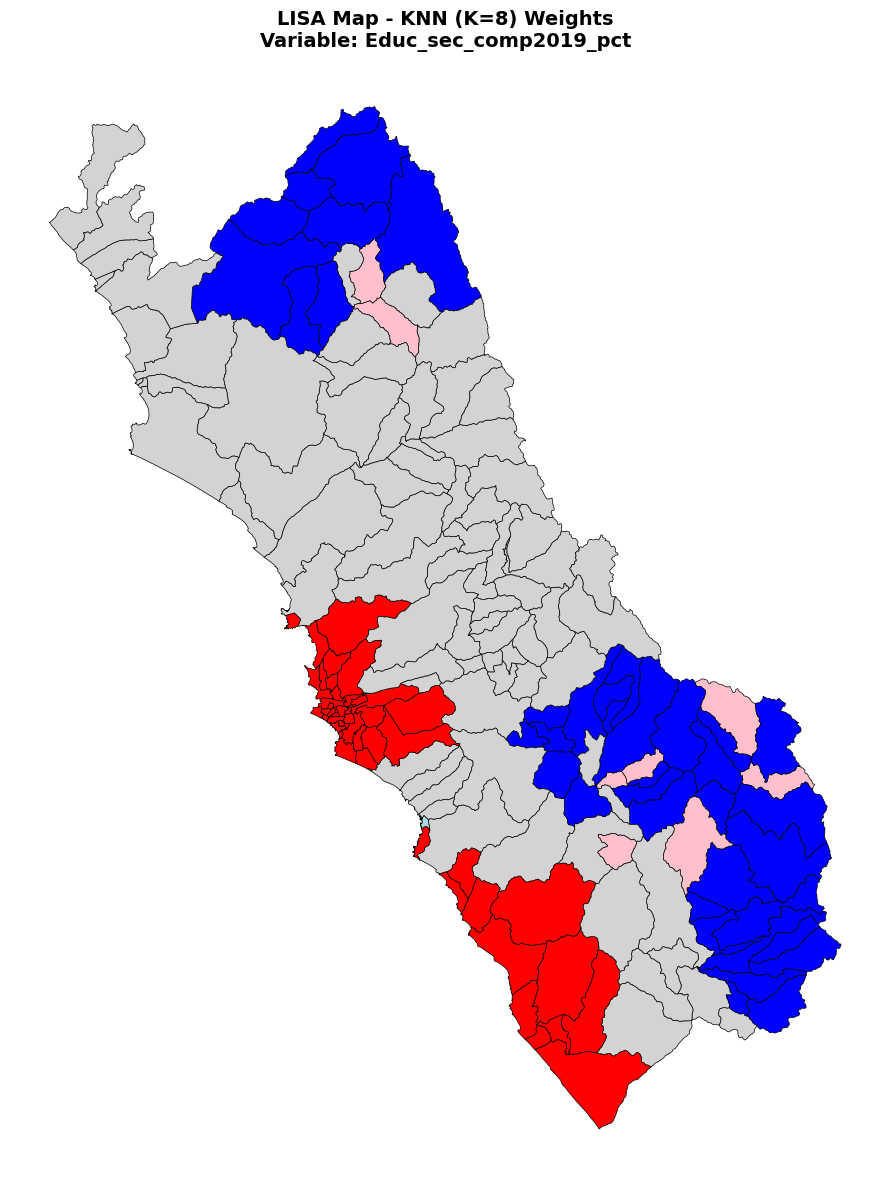


✓ KNN LISA analysis complete


In [67]:
# ============================================================================
# CODE CHUNK 8: Redo the LISA MAP using KNN neighborhood matrix (K=8)
# ============================================================================
# KNN (K-Nearest Neighbors): Each district has exactly K nearest neighbors
# K=8 means we consider the 8 closest districts as neighbors (by distance)
# This differs from Queen which uses shared boundaries

# Create centroids from district polygons for distance calculations
# KNN requires point geometries, not polygons
lima_centroids = lima.copy()
lima_centroids['geometry'] = lima_centroids.geometry.centroid

# Create KNN weights with K=8 nearest neighbors
# Uses district centroids for distance calculations
w_knn = Graph.build_knn(lima_centroids, k=8)
print("✓ KNN weights created with K=8 neighbors")
print(f"Number of spatial units: {w_knn.n}")
print("Each district has exactly 8 neighbors")

# Row-standardize the KNN weights matrix
# This normalizes so each neighbor contributes equally
w_knn_normalized = w_knn.transform('r')
print("✓ KNN weights matrix row-standardized (normalized)")

# Calculate Local Moran's I using KNN weights
# Same LISA calculation, but with different neighbor definition
lisa_knn = Moran_Local(lima['Educ_sec_comp2019_pct'], w_knn_normalized)
print(f"✓ LISA calculated using KNN weights for {len(lima)} districts")

# Store KNN LISA results
lima['lisa_knn'] = lisa_knn.q
lima['lisa_sig_knn'] = lisa_knn.p_sim < 0.05
print(f"Significant clusters with KNN (p<0.05): {lima['lisa_sig_knn'].sum()}")

# Visualize LISA clusters with KNN weights
fig, ax = plt.subplots(figsize=(14, 12))

# Define colors for each LISA category
lisa_colors = {1: 'red', 2: 'lightblue', 3: 'blue', 4: 'pink', 0: 'lightgrey'}

# Apply colors based on significance
lima['lisa_color_knn'] = lima.apply(
    lambda row: lisa_colors[row['lisa_knn']] if row['lisa_sig_knn'] else 'lightgrey',
    axis=1
)

# Plot the map with colors
lima.plot(ax=ax, color=lima['lisa_color_knn'], edgecolor='black', linewidth=0.5)
plt.title('LISA Map - KNN (K=8) Weights\nVariable: Educ_sec_comp2019_pct',
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("\n✓ KNN LISA analysis complete")

In [68]:
# ============================================================================
# CODE CHUNK 9: For this new LISA results, redo step 7
# ============================================================================
# Apply the same labeling process to KNN results for consistency
# This allows direct comparison between Queen and KNN methods

# Map KNN numeric LISA codes to text labels (same mapping as Queen)
lima['lisa_category_knn'] = lima['lisa_knn'].map(lisa_labels)

# Only keep labels for statistically significant KNN results
lima['lisa_category_knn'] = lima.apply(
    lambda row: row['lisa_category_knn'] if row['lisa_sig_knn']
    else 'Not Significant',
    axis=1
)

# Display the distribution of KNN LISA categories
print("✓ KNN LISA categories created and labeled")
print("\nLISA Category Distribution (KNN K=8 weights):")
print(lima['lisa_category_knn'].value_counts().sort_index())

# Show a preview of the data with both Queen and KNN results
print("\nSample of districts with both QUEEN and KNN LISA categories:")
comparison_cols = ['DISTRITO', 'lisa_category_queen', 'lisa_category_knn']
print(lima[comparison_cols].head(10))

✓ KNN LISA categories created and labeled

LISA Category Distribution (KNN K=8 weights):
lisa_category_knn
HH                 46
HL                  8
LH                  1
LL                 39
Not Significant    77
Name: count, dtype: int64

Sample of districts with both QUEEN and KNN LISA categories:
         DISTRITO lisa_category_queen lisa_category_knn
0            ALIS                  HL                HL
1          AYAUCA     Not Significant   Not Significant
2           AMBAR                  LL                LL
3           ANCON     Not Significant   Not Significant
4         ANDAJES                  HL                HL
5       ANTIOQUIA     Not Significant   Not Significant
6         ARAHUAY     Not Significant   Not Significant
7            ASIA                  HH                HH
8  ATAVILLOS ALTO     Not Significant   Not Significant
9  ATAVILLOS BAJO     Not Significant   Not Significant


In [69]:
# ============================================================================
# CODE CHUNK 10: REPORT - Compare Queen vs. KNN LISA categories
# ============================================================================
# This chunk identifies districts that belong to different groups
# when using Queen contiguity vs. KNN (K=8) neighborhood definitions

print("=" * 70)
print("COMPARATIVE ANALYSIS: QUEEN vs. KNN SPATIAL WEIGHTS")
print("=" * 70)

# Summary of LISA categories
print("\n1. SUMMARY OF LISA CATEGORIES:\n")
comparison_summary = lima.groupby('lisa_category_queen').size().to_frame('QUEEN')
comparison_summary['KNN (K=8)'] = lima.groupby('lisa_category_knn').size()
print(comparison_summary)
print()

# Identify districts that changed categories between methods
lima['category_changed'] = (lima['lisa_category_queen'] != lima['lisa_category_knn'])
districts_changed = lima[lima['category_changed']]

print("\n2. DISTRICTS WITH DIFFERENT CLASSIFICATIONS:")
print(f"   Total districts analyzed: {len(lima)}")
print(f"   Districts that CHANGED category: {len(districts_changed)}")
print(f"   Districts that remained same: {len(lima) - len(districts_changed)}")
print(f"   Percentage that changed: {len(districts_changed)/len(lima)*100:.1f}%")

print("\n3. DISTRICTS THAT DO NOT BELONG TO THE SAME GROUP:\n")
print("-" * 70)

# Detailed list of districts that changed
if len(districts_changed) > 0:
    print(f"{'DISTRITO':<25} {'QUEEN':<20} {'KNN (K=8)':<20}")
    print("-" * 70)
    
    # Show which districts changed and how they changed
    change_detail = districts_changed[['DISTRITO',
                                       'lisa_category_queen',
                                       'lisa_category_knn',
                                       'Educ_sec_comp2019_pct']].copy()
    
    change_detail.columns = ['DISTRITO', 'QUEEN Category', 'KNN Category',
                             'Education % (HS Completion)']
    
    # Sort by education level for easier interpretation
    change_detail = change_detail.sort_values('Education % (HS Completion)',
                                              ascending=False)
    
    # Print each district that changed
    for idx, row in change_detail.iterrows():
        print(f"{row['DISTRITO']:<25} {row['QUEEN Category']:<20} {row['KNN Category']:<20}")
    
    print("-" * 70)
    print(f"\nTotal: {len(districts_changed)} districts with different classifications")
    
else:
    print("All districts have the SAME category in both methods!")


COMPARATIVE ANALYSIS: QUEEN vs. KNN SPATIAL WEIGHTS

1. SUMMARY OF LISA CATEGORIES:

                     QUEEN  KNN (K=8)
lisa_category_queen                  
HH                      39         46
HL                       5          8
LL                      23         39
Not Significant        104         77


2. DISTRICTS WITH DIFFERENT CLASSIFICATIONS:
   Total districts analyzed: 171
   Districts that CHANGED category: 33
   Districts that remained same: 138
   Percentage that changed: 19.3%

3. DISTRICTS THAT DO NOT BELONG TO THE SAME GROUP:

----------------------------------------------------------------------
DISTRITO                  QUEEN                KNN (K=8)           
----------------------------------------------------------------------
COAYLLO                   Not Significant      HH                  
HUANCAYA                  Not Significant      HL                  
CHILCA                    HH                   Not Significant     
SANTA ANITA               Not 